In [ ]:
#default_exp core.config

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#export
from fastai2.data.all import *
from fastai2_audio.core.signal import *
from fastai2_audio.core.spectrogram import *
from fastai2_audio.augment.preprocess import Resample
from fastai2_audio.augment.signal import DownmixMono, CropSignal
import torchaudio.transforms as transforms
from inspect import signature
from dataclasses import make_dataclass

In [ ]:
#hide
p = untar_data(URLs.SPEAKERS10, extract_func=tar_extract_at_filename)
audio_getter = AudioGetter("", recurse=True, folders=None)
files = audio_getter(p)
ex_files = [p/f for f in ['m0005_us_m0005_00218.wav', 
                                'f0003_us_f0003_00279.wav', 
                                'f0001_us_f0001_00168.wav', 
                                'f0005_us_f0005_00286.wav',]]

In [ ]:
oa = OpenAudio(files)

# AudioBlock

In [ ]:
#export
def AudioBlock(sample_rate=16000, force_mono=True, crop_signal_to=None, cls=AudioTensor):
    tfms = [Resample(sample_rate)]
    if force_mono:
        tfms.append(DownmixMono())
    if crop_signal_to is not None:
        tfms.append(CropSignal(duration=crop_signal_to))
    return TransformBlock(type_tfms=cls.create, item_tfms=Pipeline(tfms), batch_tfms=IntToFloatTensor)

# AudioConfig
> Configurations to quickly extract representations from audio

In [ ]:
#export
def config_from_func(func, name, **kwargs):
    params = signature(func).parameters.items()
    namespace = {k:v.default for k, v in params}
    namespace.update(kwargs)
    return make_dataclass(name, namespace.keys(), namespace=namespace)

In [ ]:
#export
class AudioConfig():
    #default configurations from the wrapped function
    #make sure to pass in mel=False as kwarg for non-mel spec, and to_db=False for non db spec
    BasicSpectrogram    = config_from_func(transforms.Spectrogram, "BasicSpectrogram", mel=False, to_db=True)
    BasicMelSpectrogram = config_from_func(transforms.MelSpectrogram, "BasicMelSpectrogram", mel=True, to_db=True)
    BasicMFCC           = config_from_func(transforms.MFCC, "BasicMFCC ")
    #special configs with domain-specific defaults

    Voice = config_from_func(transforms.MelSpectrogram, "Voice", mel="True", to_db="False", f_min=50., f_max=8000., n_fft=1024, n_mels=128, hop_length=128)

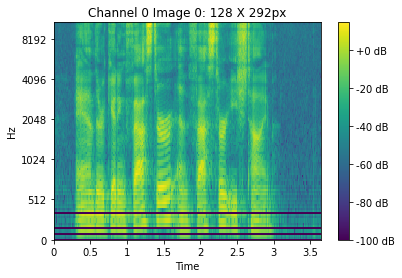

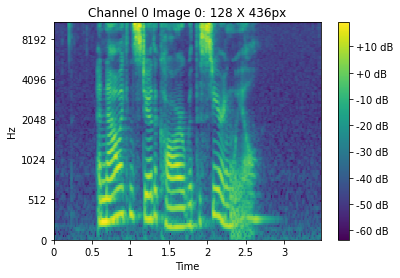

In [ ]:
# Basic Mel Spectrogram is just the Torchaudio defaults, which are currently bad, hence
# the empty melbins in the spectrogram below. We can make our own custom good ones like Voice
mel_cfg = AudioConfig.BasicMelSpectrogram()
a2mel = AudioToSpec.from_cfg(mel_cfg)
item0 = AudioTensor.create(ex_files[0])
mel_bad = a2mel(item0)
mel_bad.show()
voice_cfg = AudioConfig.Voice()
a2mel = AudioToSpec.from_cfg(voice_cfg)
mel_good = a2mel(oa(42))
mel_good.show()

In [ ]:
test_eq(mel_bad.n_fft, mel_cfg.n_fft)
# hop defaults to None in torchaudio but is set later in the code, we override this default to None
# internally in AudioToSpec to ensure the correct hop_length is stored as a sg attribute
test_ne(mel_bad.hop_length, mel_cfg.hop_length)
print("MelConfig Default Hop:", mel_cfg.hop_length)
print("Resulting Hop:",mel_bad.hop_length)

MelConfig Default Hop: None
Resulting Hop: 200


In [ ]:
sg_cfg = AudioConfig.BasicSpectrogram()
# make sure mel setting is passed down and is false for normal spectro
test_eq(sg_cfg.mel, False)

In [ ]:
#Grab a random file, test that the n_fft are passed successfully via config and stored in sg settings
oa = OpenAudio(files)
f_num = random.randint(0, len(files))
sg_cfg = AudioConfig.BasicSpectrogram(n_fft=2000, hop_length=155)
a2sg = AudioToSpec.from_cfg(sg_cfg)
sg = a2sg(oa(f_num))
test_eq(sg.n_fft, sg_cfg.n_fft)
test_eq(sg.width, int(oa(f_num).nsamples/sg_cfg.hop_length)+1)

# Example Pipelines

### DB MelSpectrogram Pipe (Standard)

In [ ]:
DBMelSpec = SpectrogramTransformer(mel=True, to_db=True)

Shape: torch.Size([1, 128, 1171])


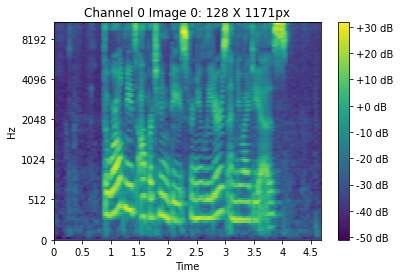

Shape: torch.Size([1, 128, 771])


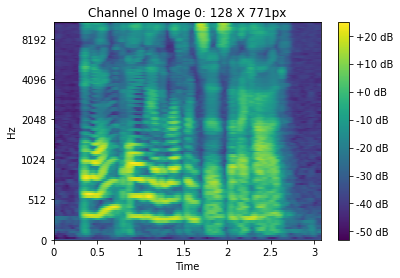

Shape: torch.Size([1, 128, 661])


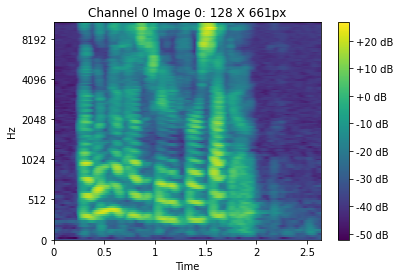

Shape: torch.Size([1, 128, 641])


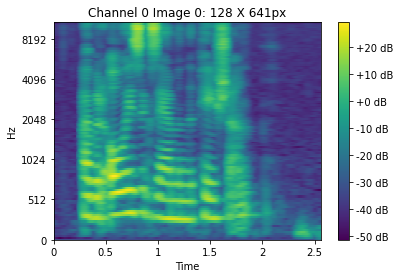

Shape: torch.Size([1, 128, 631])


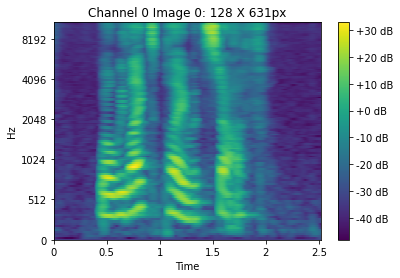

In [ ]:
mel_cfg = {'n_fft':2560,'hop_length':64}
oa = OpenAudio(files)
a2s = DBMelSpec(**mel_cfg)
db_mel_pipe = Pipeline([oa,a2s])
for i in range(5):
    print("Shape:", db_mel_pipe(i).shape)
    db_mel_pipe.show(db_mel_pipe(i))

### Raw Spectrogram (non-mel, non-db) Pipe

Shape: torch.Size([1, 201, 586])


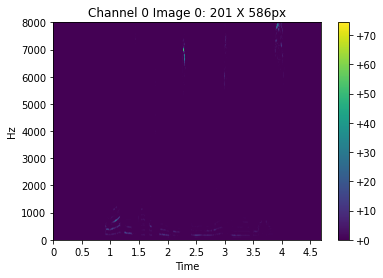

Shape: torch.Size([1, 201, 386])


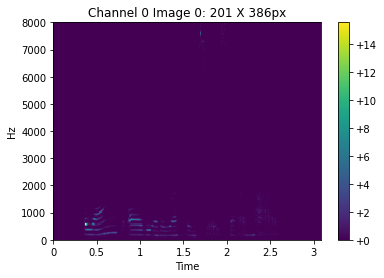

Shape: torch.Size([1, 201, 331])


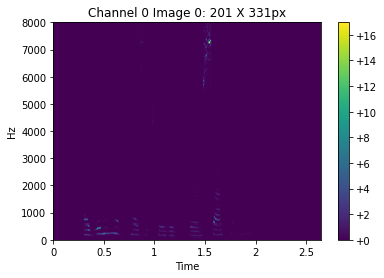

In [ ]:
cfg = {'mel':False, 'to_db':False, 'hop_length':128, 'n_fft':400}
oa = OpenAudio(files)
a2s = AudioToSpec.from_cfg(cfg)
db_mel_pipe = Pipeline([oa, a2s])
for i in range(3):
    print("Shape:", db_mel_pipe(i).shape)
    db_mel_pipe.show(db_mel_pipe(i))
    test_eq(db_mel_pipe(i).hop_length, cfg["hop_length"])

### DBScale non-melspectrogram Pipe

Shape: torch.Size([1, 513, 147])


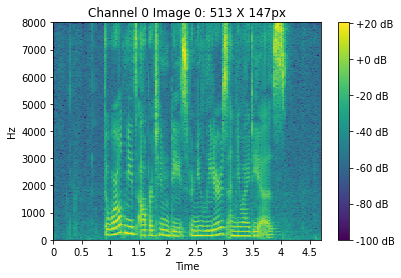

Shape: torch.Size([1, 513, 97])


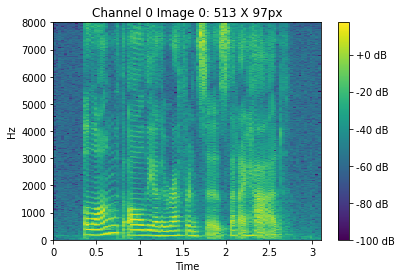

Shape: torch.Size([1, 513, 83])


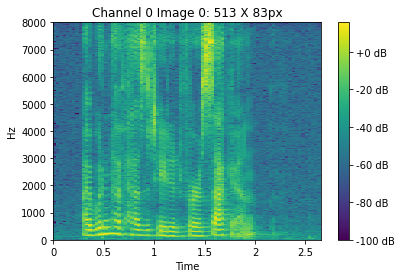

In [ ]:
oa = OpenAudio(files)
a2s = SpectrogramTransformer(mel=False)()
db_mel_pipe = Pipeline([oa, a2s])
for i in range(3): 
    print("Shape:", db_mel_pipe(i).shape)
    db_mel_pipe.show(db_mel_pipe(i))

### Pipe using from_cfg (config)

/home/scart/fastai2_audio/nbs/fastai2_audio/core/spectrogram.py:143: UserWarning: f_max is not a valid arg name and was not used
  warnings.warn(f"{kwarg} is not a valid arg name and was not used")


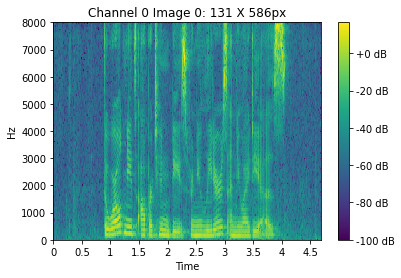

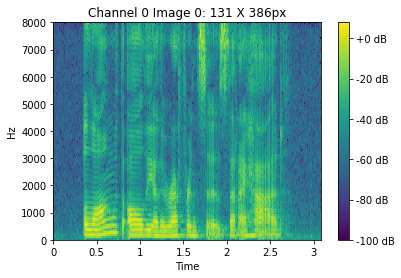

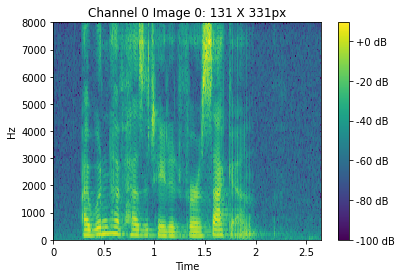

In [ ]:
#non-mel db-scale spectrogram, warning is expected as f_max is an argument to melspectrograms
cfg = {'mel':False, 'to_db':True, 'n_fft':260, 'f_max':22050., 'hop_length':128}
oa = OpenAudio(files)
a2s = AudioToSpec.from_cfg(cfg)
db_mel_pipe = Pipeline([oa, a2s])
for i in range(3): 
    db_mel_pipe.show(db_mel_pipe(i))

### MFCC Pipe

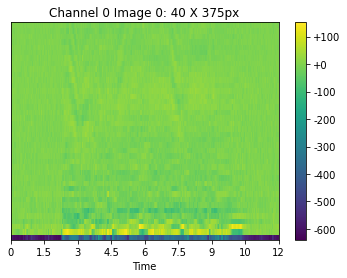

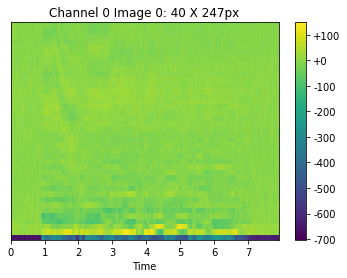

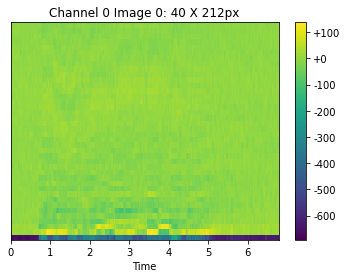

In [ ]:
db_mfcc_pipe = Pipeline([oa, AudioToMFCC(n_mfcc=40),])
for i in range(3): 
    db_mfcc_pipe.show(db_mfcc_pipe(i))

## Pipeline examples from Config

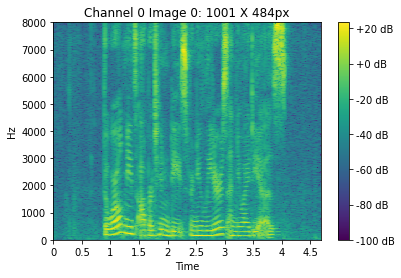

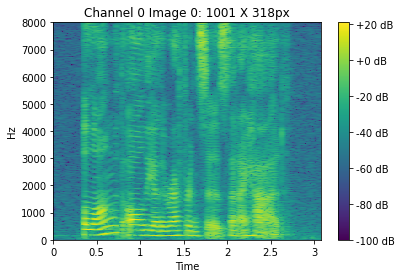

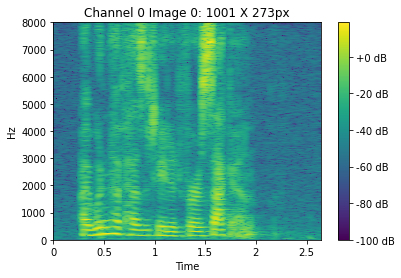

In [ ]:
oa = OpenAudio(files)
db_mel_pipe = Pipeline([oa, AudioToSpec.from_cfg(sg_cfg)])
for i in range(3): 
    db_mel_pipe.show(db_mel_pipe(i))

In [ ]:
voice_config = AudioConfig.Voice(); voice_config

Voice(sample_rate=16000, n_fft=1024, win_length=None, hop_length=128, f_min=50.0, f_max=8000.0, pad=0, n_mels=128, window_fn=<built-in method hann_window of type object at 0x7f4b310d5880>, wkwargs=None, mel='True', to_db='False')

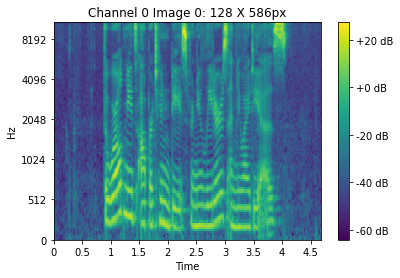

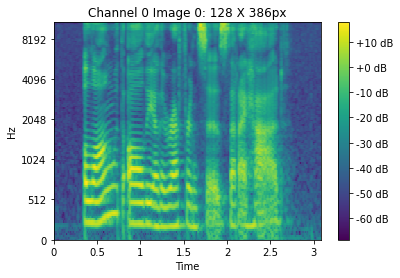

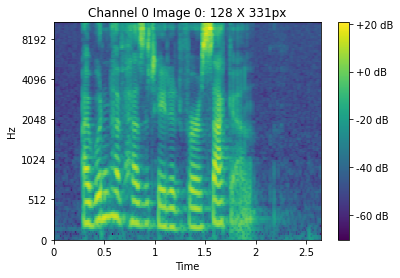

In [ ]:
oa = OpenAudio(files)
db_mel_pipe = Pipeline([oa, AudioToSpec.from_cfg(voice_config)])
for i in range(3): 
    db_mel_pipe.show(db_mel_pipe(i))

Shape torch.Size([1, 40, 209])


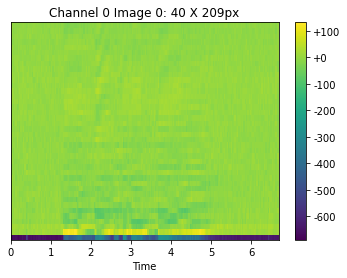

Shape torch.Size([1, 40, 212])


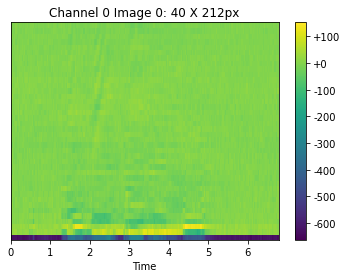

Shape torch.Size([1, 40, 228])


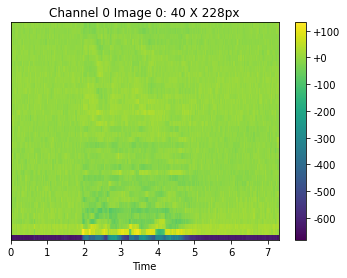

In [ ]:
mfcc_cfg = AudioConfig.BasicMFCC()
oa = OpenAudio(files)
mfcc_pipe = Pipeline([oa, AudioToMFCC.from_cfg(mfcc_cfg)])
for i in range(44,47):
    print("Shape", mfcc_pipe(i).shape)
    mfcc_pipe(i).show()

## Export

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()